In [1]:
import pandas as  pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D
from tensorflow.keras import layers,models
from tensorflow.keras.optimizers import Adam
from tqdm.keras import TqdmCallback
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
#LabelEncoder
from sklearn.preprocessing import LabelEncoder
#For commiting logs
import sqlite3 
import logging
#For known warnings 
import warnings
warnings.filterwarnings('ignore')
#To see the process bar 
from tqdm import tqdm


d:\Python3.12.3amd64\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv('Collab.csv')
data.set_index(data['PROFILEDATE'],inplace=True)

data.index= pd.to_datetime(data.index)

 
data.drop(columns='PROFILEDATE',inplace =True)
data.rename(columns={'0':'Consumption'},inplace=True)
data



,Consumption
PROFILEDATE,
2023-05-01 00:00:00,161205.718
2023-05-01 01:00:00,160413.437
2023-05-01 02:00:00,159832.061
2023-05-01 03:00:00,157430.554
2023-05-01 04:00:00,156963.253
...,...
2024-05-31 19:00:00,245884.220
2024-05-31 20:00:00,245507.742
2024-05-31 21:00:00,243348.836


In [3]:
def normalise_data(rawdata, normalise=1):
    #Input must be a DATAFRAME!!
    data = np.zeros(rawdata.shape)

    n, m = rawdata.shape
    scale = np.ones(m)
    if normalise == 0: # do not normalise
        data = rawdata

    if normalise == 1: # same normalisation for all timeseries
        data = rawdata / np.max(rawdata)

    if normalise == 2: # normalise each timeseries alone. This is the default mode
        for i in range(m):
            scale[i] = np.max(np.abs(rawdata.iloc[:, i]))
            data[:, i] = rawdata.iloc[:, i] / scale[i]
    
    return data

In [4]:
val = normalise_data(data)
val

,Consumption
PROFILEDATE,
2023-05-01 00:00:00,0.447738
2023-05-01 01:00:00,0.445538
2023-05-01 02:00:00,0.443923
2023-05-01 03:00:00,0.437253
2023-05-01 04:00:00,0.435955
...,...
2024-05-31 19:00:00,0.682927
2024-05-31 20:00:00,0.681882
2024-05-31 21:00:00,0.675885


In [6]:
specialDays = [
    #"2023-01-01",  # Yılbaşı
    #"2023-04-23",  # Ulusal Egemenlik ve Çocuk Bayramı
    "2023-05-01",  # İşçi ve Emekçi Bayramı
    #"2023-05-19",  # Atatürk'ü Anma, Gençlik ve Spor Bayramı
    "2023-07-20",  # Ramazan Bayramı Arifesi
    "2023-07-21",  # Ramazan Bayramı 1. Gün
    "2023-07-22",  # Ramazan Bayramı 2. Gün
    "2023-07-23",  # Ramazan Bayramı 3. Gün
    "2023-08-30",  # Zafer Bayramı
    "2023-09-04",  # Kurban Bayramı Arifesi
    "2023-09-05",  # Kurban Bayramı 1. Gün
    "2023-09-06",  # Kurban Bayramı 2. Gün
    "2023-09-07",  # Kurban Bayramı 3. Gün
    "2023-09-08",  # Kurban Bayramı 4. Gün
    "2023-09-09",  # Kurban Bayramı 5. Gün
    "2023-09-10",  # Kurban Bayramı 6. Gün
    #"2023-10-29",  # Cumhuriyet Bayramı
    "2024-01-01",  # Yılbaşı
    "2024-04-23",  # Ulusal Egemenlik ve Çocuk Bayramı
    "2024-05-01",  # İşçi ve Emekçi Bayramı
    #"2024-05-19"   # Atatürk'ü Anma, Gençlik ve Spor Bayramı
    ]




specialDay_list = []
for date in specialDays:
    base = pd.to_datetime(date)

    for hour in range(24):
        timestamp = base + pd.DateOffset(hours=hour)

        specialDay_list.append(timestamp)

specialDay_list = pd.to_datetime(specialDay_list)




In [7]:
def features(df, daylist):
    df.index = pd.to_datetime(df.index)
    df['Day'] = df.index.day
    df['Month'] = df.index.month
    df['Year'] = df.index.year
    df['Weekday'] = df.index.weekday
    df['Hour'] = df.index.hour
    df['SD'] = df.index.isin(daylist)
    label_encoder = LabelEncoder()
    df['SD'] = df['SD'].astype(int)
    
    return df


In [8]:
X_train = features(val,specialDay_list)
X_train

,Consumption,Day,Month,Year,Weekday,Hour,SD
PROFILEDATE,,,,,,,
2023-05-01 00:00:00,0.447738,1,5,2023,0,0,1
2023-05-01 01:00:00,0.445538,1,5,2023,0,1,1
2023-05-01 02:00:00,0.443923,1,5,2023,0,2,1
2023-05-01 03:00:00,0.437253,1,5,2023,0,3,1
2023-05-01 04:00:00,0.435955,1,5,2023,0,4,1
...,...,...,...,...,...,...,...
2024-05-31 19:00:00,0.682927,31,5,2024,4,19,0
2024-05-31 20:00:00,0.681882,31,5,2024,4,20,0
2024-05-31 21:00:00,0.675885,31,5,2024,4,21,0


In [9]:
y= X_train['Consumption']
X_train.drop(columns='Consumption',inplace=True)

In [10]:
y

PROFILEDATE
2023-05-01 00:00:00    0.447738
2023-05-01 01:00:00    0.445538
2023-05-01 02:00:00    0.443923
2023-05-01 03:00:00    0.437253
2023-05-01 04:00:00    0.435955
                         ...   
2024-05-31 19:00:00    0.682927
2024-05-31 20:00:00    0.681882
2024-05-31 21:00:00    0.675885
2024-05-31 22:00:00    0.657735
2024-05-31 23:00:00    0.639320
Name: Consumption, Length: 9528, dtype: float64

In [11]:
X_train

,Day,Month,Year,Weekday,Hour,SD
PROFILEDATE,,,,,,
2023-05-01 00:00:00,1,5,2023,0,0,1
2023-05-01 01:00:00,1,5,2023,0,1,1
2023-05-01 02:00:00,1,5,2023,0,2,1
2023-05-01 03:00:00,1,5,2023,0,3,1
2023-05-01 04:00:00,1,5,2023,0,4,1
...,...,...,...,...,...,...
2024-05-31 19:00:00,31,5,2024,4,19,0
2024-05-31 20:00:00,31,5,2024,4,20,0
2024-05-31 21:00:00,31,5,2024,4,21,0


In [12]:
y

PROFILEDATE
2023-05-01 00:00:00    0.447738
2023-05-01 01:00:00    0.445538
2023-05-01 02:00:00    0.443923
2023-05-01 03:00:00    0.437253
2023-05-01 04:00:00    0.435955
                         ...   
2024-05-31 19:00:00    0.682927
2024-05-31 20:00:00    0.681882
2024-05-31 21:00:00    0.675885
2024-05-31 22:00:00    0.657735
2024-05-31 23:00:00    0.639320
Name: Consumption, Length: 9528, dtype: float64

In [13]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

In [14]:
model = RandomForestRegressor(n_estimators=1000, random_state=42,bootstrap=False)
model.fit(X_train, y)

RandomForestRegressor(bootstrap=False, n_estimators=1000, random_state=42)

In [29]:
##Burada gelen veriyi hazırlamam gerekecek


In [62]:
def create_continuation_df(X_train, hours=720):
    """
    Creates a DataFrame with the same columns as X_train and an index that continues
    from where X_train's index ends, with an hourly frequency. Optionally fills the 'Back'
    column with values from the last 168 entries of X_train['Back'], shifted appropriately.

    Parameters:
    - X_train: The DataFrame from which to continue the index.
    - hours: The number of hours to continue the index. Defaults to 24.
    - back: Whether to fill the 'Back' column with shifted values from X_train. Defaults to True.

    Returns:
    - A new DataFrame with the specified configurations.
    """
    # Determine the last index of X_train
    last_index = X_train.index[-1]
    # Calculate the start of the new index, which is one hour after the last index of X_train
    new_index_start = last_index + pd.Timedelta(hours=1)
    # Create a new index with the specified number of hours
    new_index = pd.date_range(start=new_index_start, periods=hours, freq='H')
    # Initialize the new DataFrame with the new index and the same columns as X_train
    new_df = pd.DataFrame(index=new_index, columns=X_train.columns)
    
   
    return new_df

In [63]:
X_test = create_continuation_df(X_train)

In [64]:
X_test

,Day,Month,Year,Weekday,Hour,SD
2024-06-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2024-06-30 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-30 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-30 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-30 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
feast =[
    '2024-06-16',
    '2024-06-17',
    '2024-06-18',
    '2024-06-19']


In [66]:
feast_list =[]
for date in feast:
    base = pd.to_datetime(date)

    for hour in range(24):
        timestamp = base + pd.DateOffset(hours=hour)

        feast_list.append(timestamp)

feast_list = pd.to_datetime(feast_list)

In [67]:

X_test = features(X_test,feast_list)

In [68]:
X_test

,Day,Month,Year,Weekday,Hour,SD
2024-06-01 00:00:00,1,6,2024,5,0,0
2024-06-01 01:00:00,1,6,2024,5,1,0
2024-06-01 02:00:00,1,6,2024,5,2,0
2024-06-01 03:00:00,1,6,2024,5,3,0
2024-06-01 04:00:00,1,6,2024,5,4,0
...,...,...,...,...,...,...
2024-06-30 19:00:00,30,6,2024,6,19,0
2024-06-30 20:00:00,30,6,2024,6,20,0
2024-06-30 21:00:00,30,6,2024,6,21,0
2024-06-30 22:00:00,30,6,2024,6,22,0


In [69]:
X_test.index

DatetimeIndex(['2024-06-01 00:00:00', '2024-06-01 01:00:00',
               '2024-06-01 02:00:00', '2024-06-01 03:00:00',
               '2024-06-01 04:00:00', '2024-06-01 05:00:00',
               '2024-06-01 06:00:00', '2024-06-01 07:00:00',
               '2024-06-01 08:00:00', '2024-06-01 09:00:00',
               ...
               '2024-06-30 14:00:00', '2024-06-30 15:00:00',
               '2024-06-30 16:00:00', '2024-06-30 17:00:00',
               '2024-06-30 18:00:00', '2024-06-30 19:00:00',
               '2024-06-30 20:00:00', '2024-06-30 21:00:00',
               '2024-06-30 22:00:00', '2024-06-30 23:00:00'],
              dtype='datetime64[ns]', length=720, freq='h')

In [70]:
y_pred = model.predict(X_test)


In [71]:
def reverse_normalisation(normalised_data, scale_factors, normalise=2):
    #Input must be array
    n, m = normalised_data.shape
    reversed_data = np.zeros_like(normalised_data)
    
    if normalise == 0:  # No need
        reversed_data = normalised_data
    
    elif normalise == 1:  # CONVERTS EACH TIME SERIES(BASED ON COLUMNS)
        reversed_data = normalised_data * np.max(scale_factors)  # * MAX VALUE--According to normalise_data function
    
    elif normalise == 2:  #CONVERTS EACH TIME SERIES(BASED ON COLUMNS)
        for i in range(m):
            reversed_data[:, i] = normalised_data[:, i] * scale_factors[i]
    ##EXAMPLE
    #K = reverse_normalisation(array ,scale_factors=np.max(interval.values, axis=0))
    
    return reversed_data  # ACTUAL VALUES

In [72]:
def reverse_normalisation2(normalised_data, scale_factors, normalise=2):
    # Ensure normalised_data is a 2D array
    if normalised_data.ndim == 1:
        normalised_data = normalised_data.reshape(-1, 1)
    
    n, m = normalised_data.shape
    reversed_data = np.zeros_like(normalised_data)
    
    if normalise == 0:  # No need
        reversed_data = normalised_data
    
    elif normalise == 1:  # CONVERTS EACH TIME SERIES(BASED ON COLUMNS)
        reversed_data = normalised_data * np.max(scale_factors)  # * MAX VALUE--According to normalise_data function
    
    elif normalise == 2:  # CONVERTS EACH TIME SERIES(BASED ON COLUMNS)
        for i in range(m):
            reversed_data[:, i] = normalised_data[:, i] * scale_factors[i]
    
    # If the input was 1D, return a 1D array
    if reversed_data.shape[1] == 1:
        return reversed_data.ravel()
    
    return reversed_data  # ACTUAL VALUES

In [73]:
y_pred = reverse_normalisation2(y_pred,scale_factors=np.max(data.values, axis=0))

predictions=pd.DataFrame(y_pred,index = X_test.index)
predictions

,0
2024-06-01 00:00:00,231372.017
2024-06-01 01:00:00,228791.901
2024-06-01 02:00:00,226235.229
2024-06-01 03:00:00,221063.681
2024-06-01 04:00:00,214936.718
...,...
2024-06-30 19:00:00,183501.837
2024-06-30 20:00:00,180831.438
2024-06-30 21:00:00,186315.568
2024-06-30 22:00:00,182778.619


In [74]:
compare = pd.read_csv('Collab2.csv')
compare.set_index(compare['PROFILEDATE'],inplace=True)

compare.index= pd.to_datetime(compare.index)

 
compare.drop(columns='PROFILEDATE',inplace =True)
compare.rename(columns={'0':'Consumption'},inplace=True)
compare

,Consumption
PROFILEDATE,
2024-06-01 00:00:00,225787.809
2024-06-01 01:00:00,221788.453
2024-06-01 02:00:00,218097.783
2024-06-01 03:00:00,212045.697
2024-06-01 04:00:00,209905.464
...,...
2024-06-30 19:00:00,180524.610
2024-06-30 20:00:00,184131.372
2024-06-30 21:00:00,186961.666


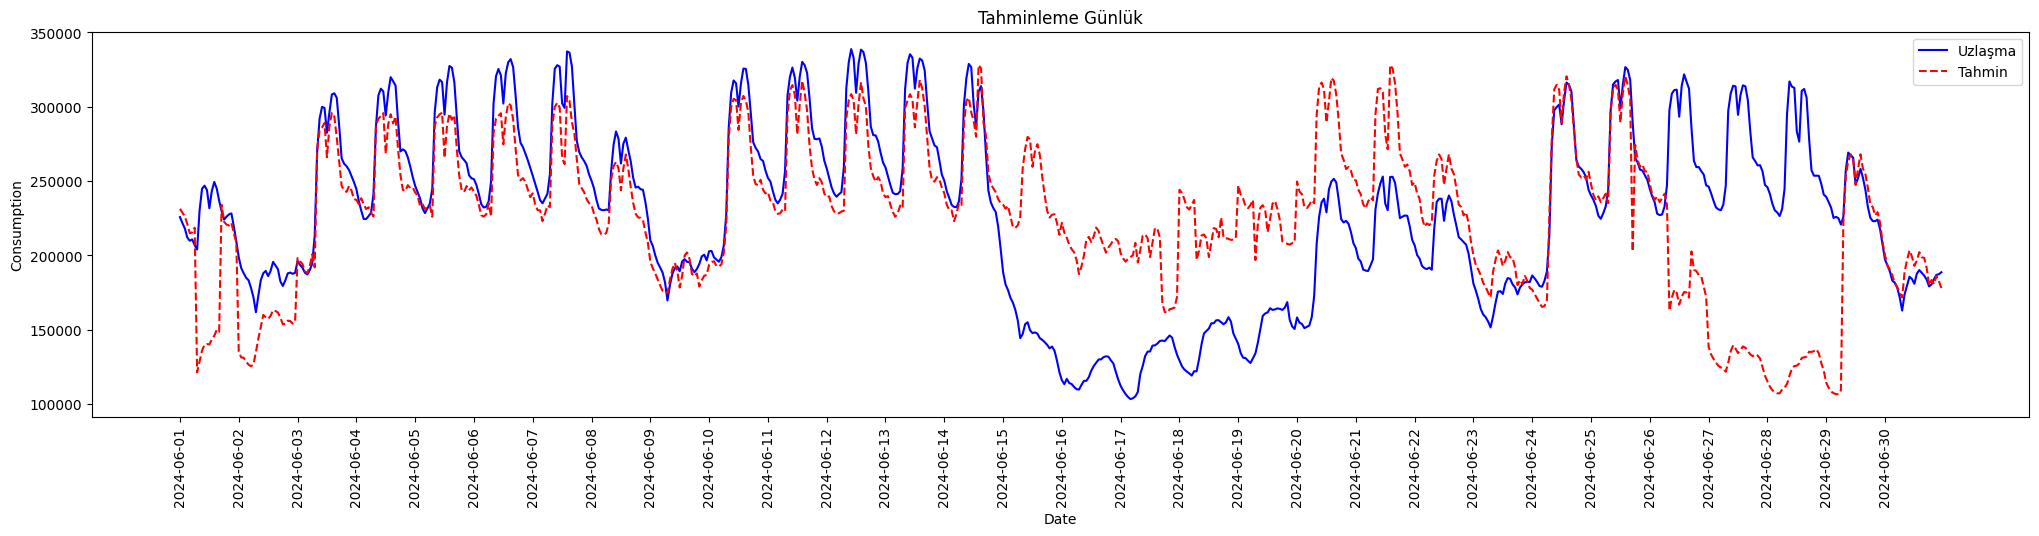

In [75]:
visual = compare[:len(X_test)]
midnight = visual.index[::24]
plt.figure(figsize=(25,5))
plt.plot(visual.index,visual.values,label='Uzlaşma',color='blue')
plt.plot(predictions.index,predictions.values,label='Tahmin',color='red',linestyle='--')

plt.xticks(rotation = 90)
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.title('Tahminleme Günlük')

plt.xticks(midnight)
plt.legend()
plt.show()

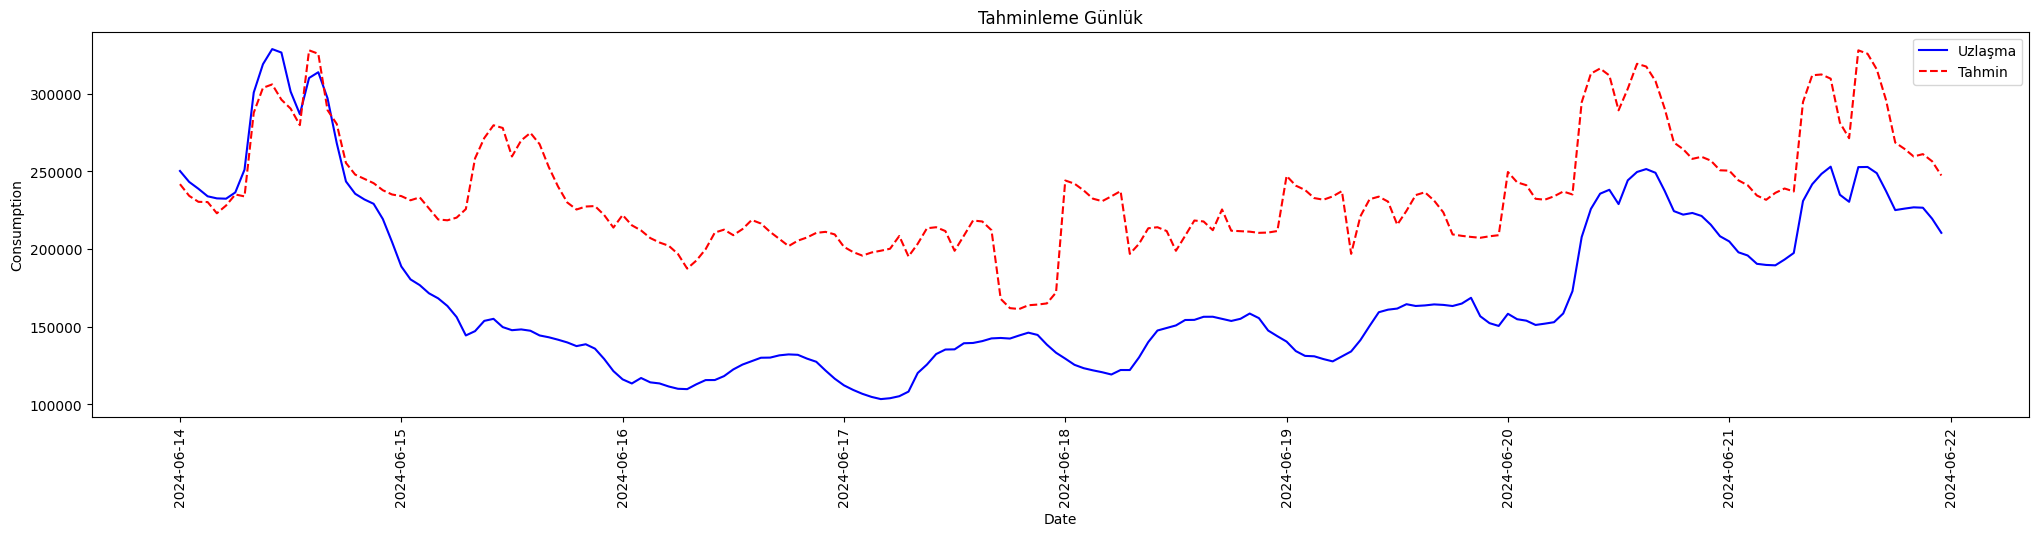

In [77]:
forlook = visual.loc['2024-06-14':'2024-06-21']

sec = predictions.loc['2024-06-14':'2024-06-21']
plt.figure(figsize=(25,5))
plt.plot(forlook.index,forlook.values,label='Uzlaşma',color='blue')
plt.plot(sec.index,sec.values,label='Tahmin',color='red',linestyle='--')

plt.xticks(rotation = 90)
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.title('Tahminleme Günlük')


plt.legend()
plt.show()


array([0.38775303, 0.44577532, 0.47338215, 0.47597801, 0.47433272,
       0.4738321 , 0.46954886, 0.47238272, 0.41238381, 0.49104676,
       0.49325803, 0.49717148, 0.41202284, 0.45870744, 0.50586125,
       0.46218025, 0.45398087, 0.44301302, 0.45809   , 0.45289411,
       0.4520944 , 0.45077521, 0.4410608 , 0.45835779])

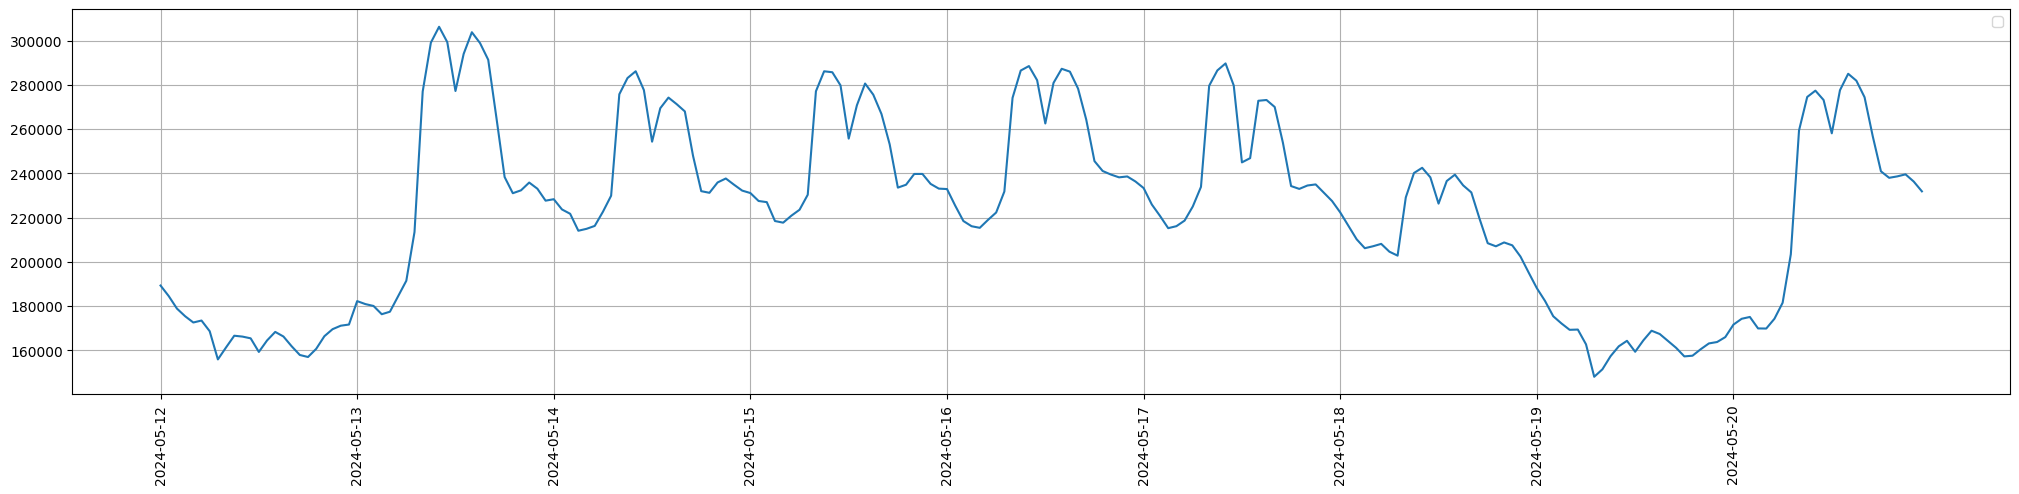

In [35]:
plot=data.loc['2024-05-12':'2024-05-20']
midnight=plot.index[::24]
plt.figure(figsize=(25,5))
plt.plot(plot)

plt.xticks(rotation=90)
plt.xticks(midnight)

plt.grid(True)
plt.legend()
plt.show()

In [ ]:
specialDays = [
    #"2023-01-01",  # Yılbaşı
    #"2023-04-23",  # Ulusal Egemenlik ve Çocuk Bayramı
    "2023-05-01",  # İşçi ve Emekçi Bayramı
    #"2023-05-19",  # Atatürk'ü Anma, Gençlik ve Spor Bayramı
    "2023-07-20",  # Ramazan Bayramı Arifesi
    "2023-07-21",  # Ramazan Bayramı 1. Gün
    "2023-07-22",  # Ramazan Bayramı 2. Gün
    "2023-07-23",  # Ramazan Bayramı 3. Gün
    "2023-08-30",  # Zafer Bayramı
    "2023-09-04",  # Kurban Bayramı Arifesi
    "2023-09-05",  # Kurban Bayramı 1. Gün
    "2023-09-06",  # Kurban Bayramı 2. Gün
    "2023-09-07",  # Kurban Bayramı 3. Gün
    "2023-09-08",  # Kurban Bayramı 4. Gün
    "2023-09-09",  # Kurban Bayramı 5. Gün
    "2023-09-10",  # Kurban Bayramı 6. Gün
    #"2023-10-29",  # Cumhuriyet Bayramı
    "2024-01-01",  # Yılbaşı
    "2024-04-23",  # Ulusal Egemenlik ve Çocuk Bayramı
    "2024-05-01",  # İşçi ve Emekçi Bayramı
    #"2024-05-19"   # Atatürk'ü Anma, Gençlik ve Spor Bayramı
    ]

In [80]:
bayram1 = data.loc['2023-07-20':'2023-07-27']
bayram2 = data.loc['2023-09-04':'2023-09-11']
sonbayram = visual.loc['2024-06-14':'2024-06-21']

predy = predictions.loc['2024-06-14':'2024-06-21']


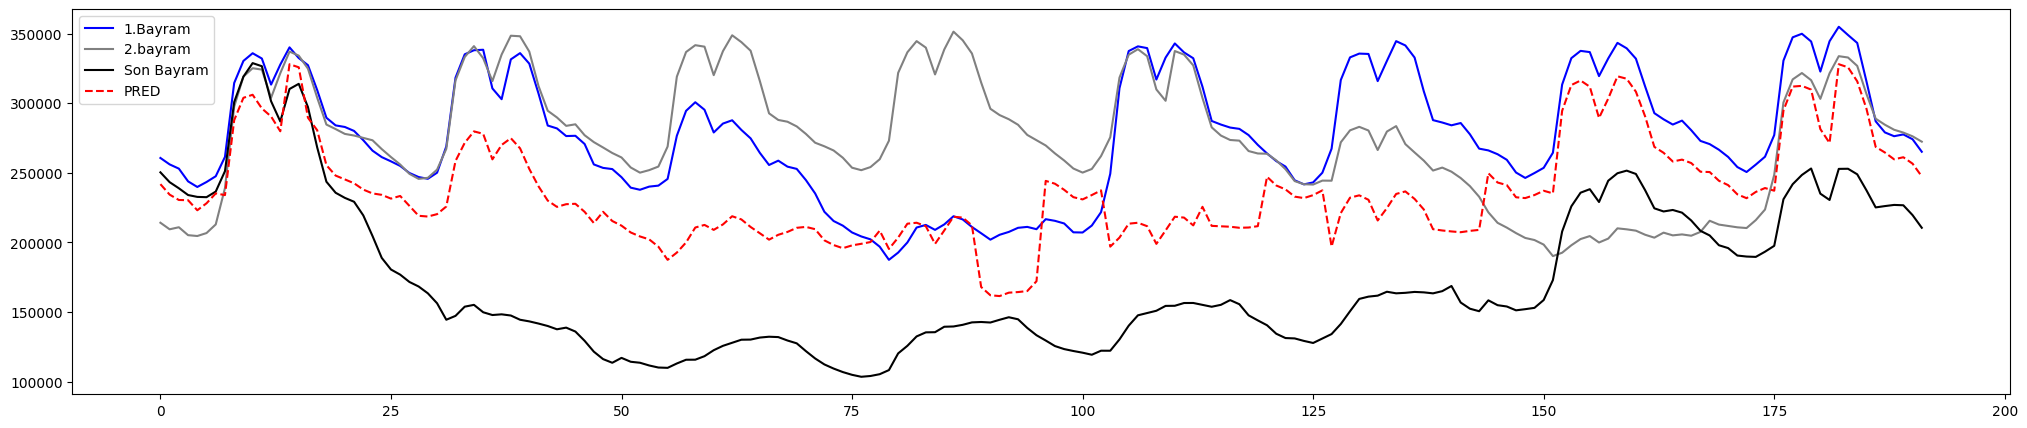

In [81]:
bayram1.reset_index()
bayram2.reset_index()
sonbayram.reset_index()
predy.reset_index()



plt.figure(figsize=(25,5))

plt.plot(bayram1.values,label='1.Bayram',color='blue')
plt.plot(bayram2.values,label='2.bayram',color='grey')
plt.plot(sonbayram.values,label='Son Bayram',color='black')


plt.plot(predy.values,label='PRED',color='red',linestyle='--')

plt.legend()
plt.show()

In [82]:
prep = pd.read_csv('UL_TKT.csv')



In [84]:
prep

,OWNERSERNO,PROFILEDATE,TUKETIM
0,277785,20220925150000,95.40
1,227367,20220610000000,968.76
2,232983,20220610000000,564.42
3,310536,20220610000000,269.10
4,227824,20220610000000,144.90
...,...,...,...
66001985,358801,20240704150000,71.68
66001986,358801,20240704160000,75.84
66001987,358801,20240704170000,78.72
66001988,358801,20240704180000,88.48


In [85]:
new_feature = prep.groupby('PROFILEDATE')['OWNERSERNO'].nunique()
new_feature

PROFILEDATE
20200701000000     998
20200701010000     998
20200701020000     998
20200701030000     998
20200701040000     998
                  ... 
20240705080000    3874
20240705090000    3856
20240705100000    3712
20240705110000    3673
20240705120000     953
Name: OWNERSERNO, Length: 35173, dtype: int64

In [86]:
new_feature = pd.DataFrame(new_feature,index=new_feature.index)
new_feature

,OWNERSERNO
PROFILEDATE,
20200701000000,998
20200701010000,998
20200701020000,998
20200701030000,998
20200701040000,998
...,...
20240705080000,3874
20240705090000,3856
20240705100000,3712


In [95]:
# Assuming new_feature.index is already in a recognizable datetime format like '2020-07-01 00:00'
new_feature.index = pd.to_datetime(new_feature.index).strftime('%Y-%m-%d %H:%M:%S')
new_feature

,TotalCustomer
PROFILEDATE,
2020-07-01 00:00:00,998
2020-07-01 01:00:00,998
2020-07-01 02:00:00,998
2020-07-01 03:00:00,998
2020-07-01 04:00:00,998
...,...
2024-07-05 08:00:00,3874
2024-07-05 09:00:00,3856
2024-07-05 10:00:00,3712


In [96]:
new_feature.rename(columns={'OWNERSERNO':'TotalCustomer'},inplace=True)

In [100]:
part1 = new_feature.loc['2023-05-01':'2024-06-01']
part1

,TotalCustomer
PROFILEDATE,
2023-05-01 00:00:00,3797
2023-05-01 01:00:00,3797
2023-05-01 02:00:00,3797
2023-05-01 03:00:00,3797
2023-05-01 04:00:00,3797
...,...
2024-05-31 19:00:00,4748
2024-05-31 20:00:00,4748
2024-05-31 21:00:00,4748
